# **Apple Stock Price from 1980-2021**

#### **À propos du Dataset:**

Ce jeu de données capture les informations historiques sur le prix des actions d'Apple Inc., offrant une perspective complète sur la performance financière de l'entreprise au fil du temps. Chaque enregistrement correspond à une date spécifique, allant du 12 décembre 1980 au 17 juin 2022. Voici un aperçu des colonnes du jeu de données :

***Date :*** La date de l'enregistrement du prix de l'action, fournissant une chronologie pour le jeu de données.

***Open :*** Le prix d'ouverture, représentant le prix initial de l'action d'Apple Inc. lors d'une journée de trading donnée.

***High :*** Le prix le plus élevé pendant une période spécifique, fournissant des informations sur les niveaux de prix maximaux.

***Low :*** Le prix le plus bas observé pendant une période définie, indiquant les fluctuations potentielles de la valeur.

***Close :*** Le prix de clôture, représentant le dernier prix enregistré à la fin d'une session de trading régulière.

***Adj Close (Prix de clôture ajusté) :*** Ajuste le prix de clôture en fonction des actions de l'entreprise (comme les dividendes et les fractionnements), offrant une représentation plus précise de la valeur réelle de l'action.

***Volume :*** Mesure le nombre d'actions échangées, fournissant des informations sur l'intérêt et l'activité des actions d'Apple Inc.

## **Importer les bibliothèques**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import tensorflow as tf

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

## **charger et inspecter le jeu de données**

In [39]:
df = pd.read_csv("AAPL.CSV")

In [40]:
# Aperçu des premieres lignes du dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [41]:
# Aperçu des dernieres lignes du dataset
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900
10467,2022-06-17,130.070007,133.080002,129.809998,131.559998,131.559998,134118500


In [42]:
# affichage de toutes les colonnes du dataset 
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [43]:
#Verification de la dimension du dataset
print("Shape of dataset:", df.shape)

Shape of dataset: (10468, 7)


# **Prétraitement de données**

#### **Vérification du type des données**

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


 Le type de la colonne "Date" doit être converti dans un format approprié afin que nous puissions travailler avec cette variable lors de la visualisation des données.

#### **Conversion de la colonne 'Date' en format datetime**

In [45]:
df["Date"] = pd.to_datetime(df["Date"])

#### **Définition de 'Date' comme index**

In [46]:
df.set_index('Date', inplace=True)

#### **Détection et suppression des anomalies**

In [52]:
# Calcul de la moyenne et de l'écart-type des prix de clôture
mean_close = df['Close'].mean()
std_close = df['Close'].std()

# Définir les seuils pour l'anomalie (3 écarts-types)
threshold_upper = mean_close + 1.5 * std_close
threshold_lower = mean_close - 1.5 * std_close

# Détecter les anomalies
anomalies = df[(df['Close'] > threshold_upper) | (df['Close'] < threshold_lower)]

# Afficher les anomalies détectées
print(f"Anomalies détectées : {anomalies.shape[0]}")

# Supprimer les anomalies du dataset
df_clean = df[(df['Close'] <= threshold_upper) & (df['Close'] >= threshold_lower)]

# Vérifier que les anomalies ont été supprimées
print(f"Shape du dataset après suppression des anomalies : {df_clean.shape}")

Anomalies détectées : 650
Shape du dataset après suppression des anomalies : (9818, 6)


#### **Réduction du shape du dataset**

In [53]:
df_resampled = df_clean.resample('W').mean()  # 'W' pour hebdomadaire, 'M' pour mensuel
df_resampled.shape

(2052, 6)

#### **Vérification des valeurs manquantes**

In [59]:
df_resampled.isna().sum()

Open         18
High         18
Low          18
Close        18
Adj Close    18
Volume       18
dtype: int64

In [61]:
df_resampled = df_resampled.dropna()

#### **Vérification des doublons**

In [60]:
df_resampled.duplicated().sum()

17

In [62]:
df_resampled = df_resampled.drop_duplicates()

In [63]:
df_resampled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-14,0.128348,0.128906,0.128348,0.128348,0.100178,469033600.0
1980-12-21,0.119196,0.119531,0.118973,0.118973,0.092861,98026880.0
1980-12-28,0.143415,0.143973,0.143415,0.143415,0.111938,46972800.0
1981-01-04,0.156250,0.156668,0.155971,0.155971,0.121739,54863200.0
1981-01-11,0.142411,0.142522,0.141964,0.141964,0.110806,39580800.0


# **Analyse Exploratoire**

#### **Statistiques descriptives**

In [64]:
df_resampled.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2.034000e+03
mean,7.601592,7.677375,7.523398,7.600350,6.979917,3.445592e+08
std,13.359302,13.488634,13.233319,13.356166,12.668770,3.022925e+08
min,0.050921,0.051200,0.050641,0.050641,0.039527,6.186880e+06
25%,0.266835,0.272165,0.261618,0.266459,0.225979,1.493318e+08
50%,0.425938,0.433967,0.417786,0.426625,0.356602,2.385773e+08
75%,7.591549,7.630331,7.517826,7.576054,6.477661,4.355204e+08
max,63.985001,67.500000,62.000000,62.057499,61.126507,2.342082e+09


#### **Visualisation de l'évolution du prix de clôture**

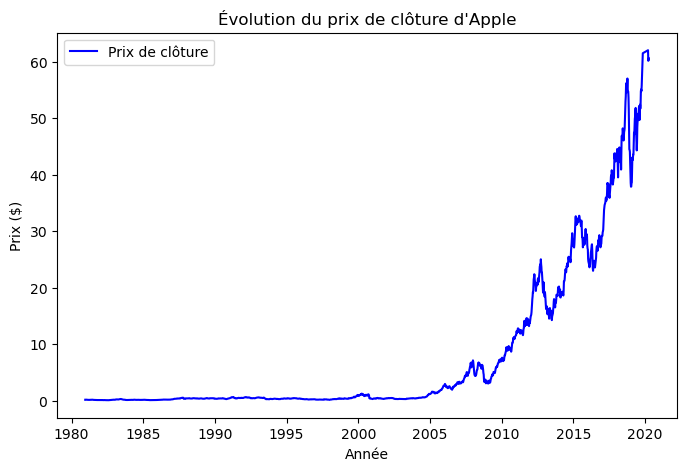

In [66]:
plt.figure(figsize=(8,5))
plt.plot(df_resampled['Close'], label="Prix de clôture", color='blue')
plt.title("Évolution du prix de clôture d'Apple")
plt.xlabel("Année")
plt.ylabel("Prix ($)")
plt.legend()
plt.show()

##### Cela indique qu'il y a eu une fluctuation significative des prix de clôture notament apès 2008.

#### **Test de stationnarité (Dickey-Fuller)**


In [67]:
series=df_resampled['Close']
# Test ADF pour la stationnarité
result = adfuller(series)
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")
for key, valeur in result[4].items():
    print(f"valeur critique {key}: {valeur}")

# Si le p-value est supérieur à 0.05, les données ne sont pas stationnaires
if result[1] > 0.05:
    print("La série temporelle n'est pas stationnaire, une différenciation sera nécessaire.")
else:
    print("La série temporelle est stationnaire.")

ADF Statistic: 3.1651505819508965
P-value: 1.0
valeur critique 1%: -3.4336124232421144
valeur critique 5%: -2.8629811656983755
valeur critique 10%: -2.5675372145497732
La série temporelle n'est pas stationnaire, une différenciation sera nécessaire.


#### **Décomposition de la série temporelle**


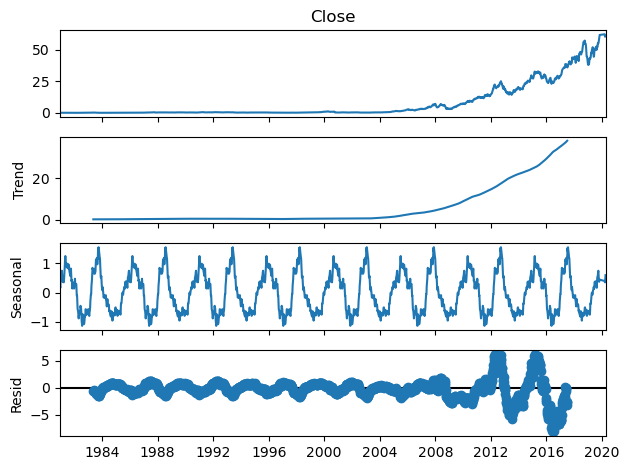

In [68]:
decomposition = seasonal_decompose(series, model='additive', period=252) # 252 jours ≈ 1 an boursier
decomposition.plot()
plt.show()

La décomposition de la série temporelle permet d'analyser les composants du prix de clôture de l'action Apple :

Prix de clôture (Close) : Cette courbe illustre l'évolution générale du prix de l'action au fil du temps, montrant une forte croissance à partir de 2010, culminant en 2020. Cela met en évidence une tendance haussière significative.

Tendance (Trend) : La tendance révèle une augmentation progressive du prix de l'action, particulièrement marquée après 2010, soulignant la dynamique positive de l'entreprise.

Saisonnalité (Seasonal) : La composante saisonnière montre des variations périodiques, bien que modestes en comparaison de la tendance générale. Ces fluctuations peuvent être attribuées à des cycles économiques ou à des facteurs internes spécifiques à l'entreprise.

Résidus (Resid) : Les résidus représentent les écarts par rapport à la tendance et à la saisonnalité. Avant 2020, ils apparaissent relativement stables, mais une plus grande volatilité est observable après cette date, probablement en réponse à des événements imprévus tels que la pandémie de COVID-19.

Ce cadre d'analyse permet de mieux comprendre les dynamiques à l'œuvre dans le prix de l'action d'Apple au fil des ans.

## **Identification des Paramètres ARIMA (p, d, q)**

#### **Tracer les graphiques ACF et PACF pour identifier les paramètres ARIMA initiaux**

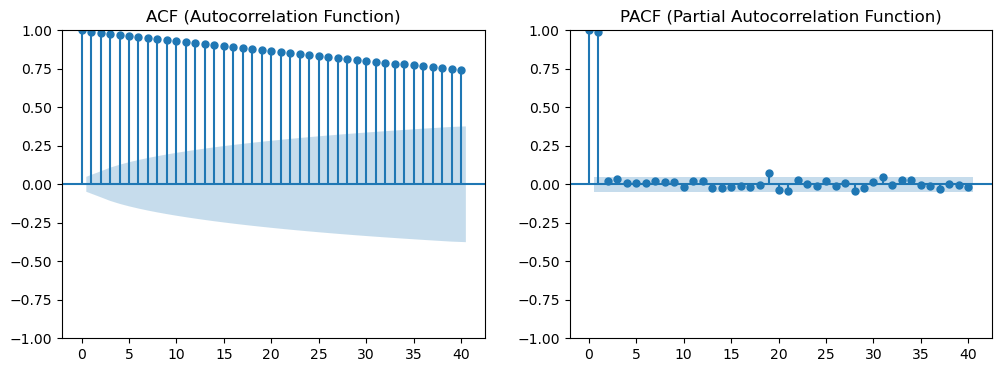

In [69]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(series) * 0.8)  # 80% entraînement, 20% test
train, test = series.iloc[:train_size], series.iloc[train_size:]

# ACF et PACF pour ajuster les paramètres ARIMA
# Tracer le graphique ACF
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(train, lags=40, ax=plt.gca())
plt.title("ACF (Autocorrelation Function)")

# Tracer le graphique PACF
plt.subplot(1, 2, 2)
plot_pacf(train, lags=40, ax=plt.gca())
plt.title("PACF (Partial Autocorrelation Function)")
plt.show()

D'après les graphiques ACF et PACF :

ACF (Autocorrelation Function) : On observe une décroissance très lente avec des valeurs élevées pour tous les retards, ce qui est caractéristique d'un processus non stationnaire (probablement une série avec une tendance).
PACF (Partial Autocorrelation Function) : Il montre une coupure nette après le premier lag, ce qui suggère un modèle AR(1).

Détermination de p et q :

p=1 (car le PACF coupe après le lag 1, indiquant un processus AR(1))
q=0 (car l'ACF ne présente pas de coupure nette mais une décroissance lente

Paramètre d (différenciation) :
la serie n'est pas Stationnaire =>d=1 ou d=2

#### **Effectuez une recherche par grille sur (p, d, q) pour minimiser le critère AIC**

In [70]:
import warnings

# Supprimer les avertissements
warnings.filterwarnings("ignore")
# Recherche par grille pour les paramètres ARIMA
def grid_search_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:
            continue
    return best_cfg, best_score

In [71]:
# Définir les plages pour p, d, q
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_cfg, best_score = grid_search_arima(train, p_values, d_values, q_values)
print(f"Meilleurs paramètres ARIMA: {best_cfg} avec AIC: {best_score}")

Meilleurs paramètres ARIMA: (1, 1, 4) avec AIC: -2314.40431439892


#### **Validation Walk-Forward :**

In [72]:
history = list(train)
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit()  # Ne pas utiliser start_params
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])
print("Predictions terminées")

Predictions terminées


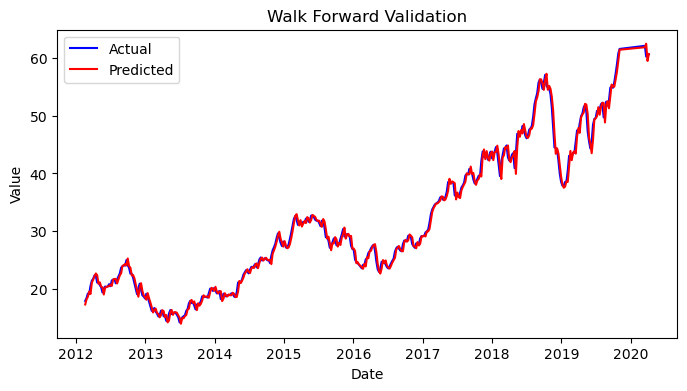

In [73]:
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 4))
plt.plot(test.index, test, label="Actual", color="blue")
plt.plot(test.index, predictions, label="Predicted", color="red")
plt.title("Walk Forward Validation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

#### **Évaluation des Performances :** 

In [74]:
# Calcul des métriques
residuals = test.values - np.array(predictions)
residual_forecast_error = np.mean(residuals)
forecast_bias = residual_forecast_error
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Residual Forecast Error: {residual_forecast_error}")
print(f"Forecast Bias: {forecast_bias}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Residual Forecast Error: 0.07205127909531887
Forecast Bias: 0.07205127909531887
Mean Absolute Error: 0.6384200398212027
Mean Squared Error: 0.7475404258747447
Root Mean Squared Error: 0.8646042018604494


#### **Modèle de persistance (Baseline)**

In [75]:
# Modèle de persistance (Baseline)
persistence_predictions = test.shift(1).dropna()
test_persistence = test[1:]
mse_baseline = mean_squared_error(test_persistence, persistence_predictions)
rmse_baseline = np.sqrt(mse_baseline)
print(f"Persistence Model RMSE: {rmse_baseline}")

Persistence Model RMSE: 0.9210906212096597


# **Modélisation avec Deep Learning**

## **ANN (Artificial Neural Networks)**

**Pretraitement de données**

In [76]:
# Sélectionner la colonne cible (prix de clôture, par exemple)
data = df_resampled[['Close']].values

# Normalisation des données
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Création des séquences temporelles
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Utiliser les 30 derniers jours pour prédire le suivant
X, y = create_sequences(data_scaled, seq_length)

# Division des données en train et test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Creation et entraînement du model:**

In [77]:
# Construire le modèle ANN avec régularisation Dropout
model_ann = keras.Sequential([
    keras.layers.Flatten(input_shape=(seq_length, 1)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),  # Dropout de 20%
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),  # Dropout de 20%
    keras.layers.Dense(1)
])

model_ann.compile(optimizer='adam', loss='mse')
# Entraînement du modèle
history = model_ann.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0996e-04 - val_loss: 0.0024
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2106e-04 - val_loss: 0.0016
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1843e-04 - val_loss: 0.0028
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2012e-04 - val_loss: 0.0019
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0983e-04 - val_loss: 9.2134e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0217e-04 - val_loss: 0.0092
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0540e-04 - val_loss: 0.0021
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3561e-04 - val_loss: 0.0031
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2644e-05 - val_loss: 0.0029
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1207e-04 - val_loss: 0.0032
Epoch 1

**Prédiction et Évaluation du Modèle  📊**

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


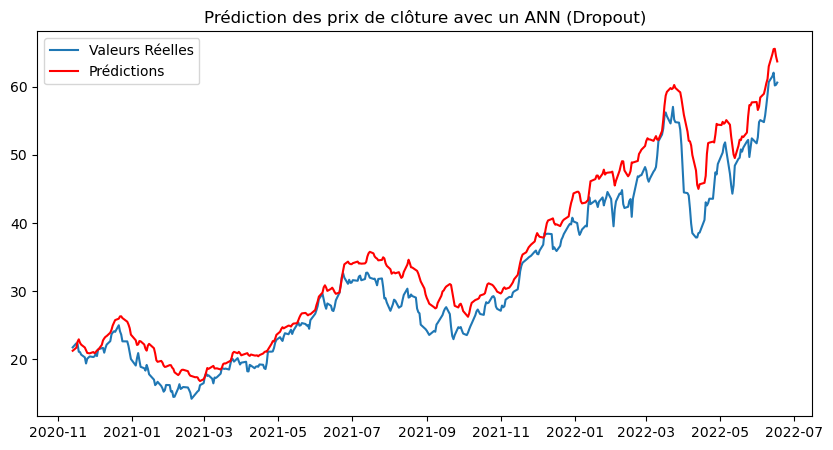

In [78]:
# Prédictions
y_pred = model_ann.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label='Valeurs Réelles')
plt.plot(df.index[-len(y_test):], y_pred_rescaled, label='Prédictions',color='red')
plt.legend()
plt.title('Prédiction des prix de clôture avec un ANN (Dropout)')
plt.show()


In [79]:
# Calcul de la MSE
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error (MSE): {mse}")

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calcul du MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Calcul du R²
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Coefficient de détermination (R²): {r2}")

# Calcul du R² ajusté
n = len(y_test_rescaled)  # Nombre d'observations
p = X_test.shape[1]  # Nombre de prédicteurs (colonnes dans X_test)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"R² Ajusté: {r2_adj}")

Mean Squared Error (MSE): 13.287679646752007
Root Mean Squared Error (RMSE): 3.6452269677966567
Mean Absolute Error (MAE): 3.0279055876761953
Coefficient de détermination (R²): 0.9062903712803896
R² Ajusté: 0.8986922932760969


## LSTM

**Creation et entraînement du model:**

In [80]:
# Création du modèle LSTM avec Dropout uniquement
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.1))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50))
model.add(Dropout(0.1))

model.add(Dense(units=1))

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 5.8150e-04 - val_loss: 0.0087
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 1.4097e-04 - val_loss: 0.0055
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 8.8196e-05 - val_loss: 0.0150
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.3488e-04 - val_loss: 0.0024
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 8.4507e-05 - val_loss: 0.0040
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.7951e-04 - val_loss: 0.0026
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 7.2398e-05 - val_loss: 0.0020
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.8825e-05 - val_loss: 0.0119
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 5.6222e-05 - val_loss: 0.0030
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 5.1325e-05 - val_loss: 0.0020
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.0033e-04 - val_loss: 0.0

**Prédiction et Évaluation du Modèle  📊**

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


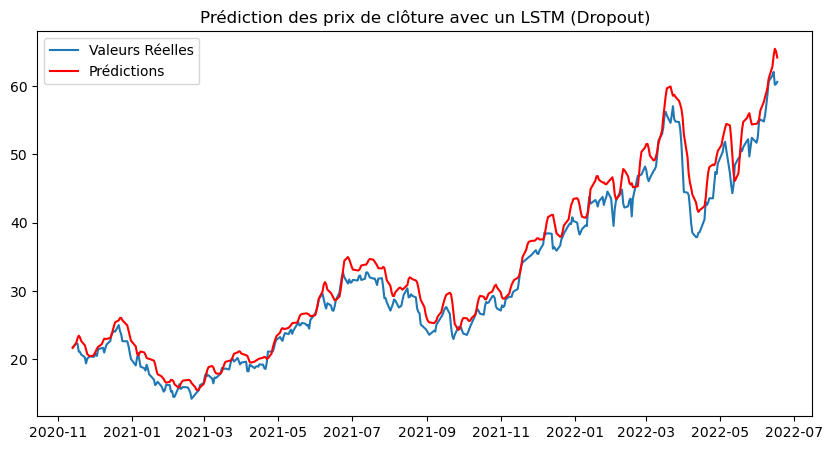

In [81]:
# Prédictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label='Valeurs Réelles')
plt.plot(df.index[-len(y_test):], y_pred_rescaled, label='Prédictions', color='red')
plt.legend()
plt.title('Prédiction des prix de clôture avec un LSTM (Dropout)')
plt.show()

In [82]:
# Calcul de la MSE
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error (MSE): {mse}")

# Calcul de la RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

from sklearn.metrics import mean_absolute_error, r2_score

# Calcul du MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Calcul du R²
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Coefficient de détermination (R²): {r2}")

# Calcul du R² ajusté
n = len(y_test_rescaled)  # Nombre d'observations
p = X_test.shape[1]  # Nombre de prédicteurs (colonnes dans X_test)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"R² Ajusté: {r2_adj}")

Mean Squared Error (MSE): 5.713779439367381
Root Mean Squared Error (RMSE): 2.3903513213265075
Mean Absolute Error (MAE): 1.9167201018182087
Coefficient de détermination (R²): 0.9597043152692395
R² Ajusté: 0.956437097588367
